In [1]:
from xmitgcm import open_mdsdataset
import xgcm
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import xarray as xr
import vertmodes
from scipy.interpolate import InterpolatedUnivariateSpline

import warnings

warnings.filterwarnings('ignore')

In [2]:
currentDirectory = os.getcwd()
data_dir = currentDirectory[:-7] + '/input/'
print(data_dir)

/scratch/jxchang/HighRes1/results/TideU008N0LinH200ho140Ah0200Cdqdt003/input/


In [3]:
iT=range(4,7)
P=12.4*60*60
dt=1860
t_st=int(P*iT[0])
t_en=int(P*(iT[-1]))
iters=range(t_st,t_en,dt)
print(iters)

range(178560, 267840, 1860)


In [4]:
ds1 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['statevars'],iters=iters)
tidaltime = ds1.time / pd.Timedelta("12.4h")
ds1=ds1.assign_coords(TidalCycles=("time", tidaltime.data))

In [5]:
print(ds1)

<xarray.Dataset>
Dimensions:      (XC: 1440, XG: 1440, YC: 120, YG: 120, Z: 40, Zl: 40, Zp1: 41, Zu: 40, time: 48)
Coordinates:
  * XC           (XC) float64 356.8 1.06e+03 1.745e+03 ... 7.894e+04 7.964e+04
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
  * YG           (YG) float64 0.0 25.0 50.0 ... 2.925e+03 2.95e+03 2.975e+03
  * Z            (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -187.5 -192.5 -197.5
  * Zp1          (Zp1) float64 0.0 -5.0 -10.0 -15.0 ... -190.0 -195.0 -200.0
  * Zu           (Zu) float64 -5.0 -10.0 -15.0 -20.0 ... -190.0 -195.0 -200.0
  * Zl           (Zl) float64 0.0 -5.0 -10.0 -15.0 ... -185.0 -190.0 -195.0
    rA           (YC, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxG          (YG, XC) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dyG          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndar

In [6]:
time=ds1.coords['time'].values/np.timedelta64(1, 's')
#time=ds2.coords['time'].values/np.timedelta64(1, 's')
xc=ds1.coords['XC']
xg=ds1.coords['XG']
yc=ds1.coords['YC']
yg=ds1.coords['YG']
z=ds1.coords['Z']
zp1=ds1.coords['Zp1']

grid = xgcm.Grid(ds1, periodic=False)
print(grid)

<xgcm.Grid>
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center


In [7]:
ds2 = open_mdsdataset(data_dir, geometry='cartesian',endian='<',prefix=['energymvars'],iters=iters)
uPbc=xr.DataArray(ds2['SDIAG6'].data, coords=[tidaltime,yc,xg], dims=['TidalCycles','YC','XG'])
print(uPbc)

<xarray.DataArray 'concatenate-116b3292d8dcdb7435e06c081c4dfd37' (TidalCycles: 48, YC: 120, XG: 1440)>
dask.array<concatenate, shape=(48, 120, 1440), dtype=float64, chunksize=(1, 120, 1440), chunktype=numpy.ndarray>
Coordinates:
  * TidalCycles  (TidalCycles) float64 4.0 4.042 4.083 ... 5.875 5.917 5.958
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04


In [8]:
dz=-ds1.Z.diff('Z').values[0]
print(dz)

5.0


In [9]:
g = 9.8
rhoNil=999.8

alpha = 2e-4 
tR_fname="../indata/TRef.bin"
tRef = np.fromfile(tR_fname)
refSalt=35.
refTemp=tRef[0]

rho2=rhoNil*(1-(alpha*(tRef-refTemp)))
print(rho2)

s = InterpolatedUnivariateSpline(-z.values, rho2, k=2)
rhol=s(-zp1.values)
Ns0=g/rhoNil*np.diff(rhol)/ds1['drF'].values
print(Ns0)
ds1["Ns0"]=xr.DataArray(Ns0,coords=[z],dims=["Z"])
ds1["rho0"]=xr.DataArray(rho2,coords=[z],dims=["Z"])
ds1['tRef']=xr.DataArray(tRef,coords=[z],dims=['Z'])

tidaltime = ds1.time / pd.Timedelta("12.4h")
ds1=ds1.assign_coords(TidalCycles=("time", tidaltime.data))
ds1=ds1.swap_dims({'time': 'TidalCycles'})
print(ds1)

[ 999.8        1004.37837649 1005.82267008 1006.20775394 1006.66329472
 1006.78566995 1006.8696037  1006.98624331 1007.10039947 1007.2146081
 1007.33636299 1007.37812997 1007.45710888 1007.55324449 1007.63389572
 1007.66446782 1007.67364771 1007.68836113 1007.69695044 1007.711887
 1007.71895969 1007.72654518 1007.73005209 1007.73237933 1007.73318594
 1007.73475566 1007.74268512 1007.74389656 1007.74442976 1007.74529036
 1007.74697721 1007.74815143 1007.75143179 1007.75471215 1007.75799251
 1007.76127287 1007.76455322 1007.76783358 1007.77111394 1007.7743943 ]
[1.23615376e-02 5.58928844e-03 1.32991065e-03 7.76435910e-04
 6.03289417e-04 1.35595443e-04 2.00923948e-04 2.31670569e-04
 2.18853431e-04 2.45946970e-04 1.55788796e-04 1.01588106e-04
 1.81519688e-04 1.82466245e-04 1.09968952e-04 2.98853792e-05
 2.24367215e-05 2.28553245e-05 2.31612474e-05 2.26569278e-05
 1.34842358e-05 1.13807365e-05 5.21316029e-06 3.08923195e-06
 8.25715168e-07 1.05906499e-05 1.01189075e-05 3.74894530e-07
 1.3124

In [10]:
ttlen=len(ds1.time)
TC=np.int(np.floor(ttlen/24))
print('the length of time:' + str(ttlen) )
print('initial temp: '+ str(tRef))
print('number of tidal cycle:'+ str(TC))

the length of time:48
initial temp: [63.59230582 40.69584406 33.47293155 31.54712706 29.26896757 28.65696899
 28.23721628 27.65390158 27.08300659 26.5118492  25.90295299 25.69407634
 25.29910279 24.81832859 24.41499174 24.26210069 24.21619203 24.14261024
 24.0996551  24.02495734 23.98958682 23.95165181 23.93411373 23.9224752
 23.91844136 23.91059116 23.87093593 23.86487752 23.86221099 23.85790713
 23.84947122 23.84359894 23.82719386 23.81078878 23.79438371 23.77797863
 23.76157355 23.74516847 23.72876339 23.71235831]
number of tidal cycle:2


In [11]:
psi,phi,ce,zph = vertmodes.vertModes(Ns0,dz)
print(np.shape(psi))
for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))

(40, 37)
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  -5.66e-12
int psi 0 psi 2:  -8.19e-14
int psi 0 psi 3:  1.06e-12


In [12]:
#adjust the normalization of vertical mode to H
nmodes=range(1,38)
H=ds1.drF.sum("Z").values
df = xr.Dataset({"psi": (["nmodes", "Z"],np.transpose(psi)*H**0.5), "phi": (["nmodes", "Z"],np.transpose(phi)*H**0.5)},coords={"nmodes":nmodes,"Z":z})
print(df)
print('int psi 0 psi 0:  ')
print((df.psi[0]*df.psi[0]*dz).sum("Z").values)
print((df.psi[0]*df.psi[1]*dz).sum("Z").values)
print((df.psi[0]*df.psi[2]*dz).sum("Z").values)
print((df.psi[0]*df.psi[3]*dz).sum("Z").values)
print((df.psi[1]*df.psi[1]*dz).sum("Z").values)
print((df.psi[2]*df.psi[2]*dz).sum("Z").values)
print((df.psi[3]*df.psi[3]*dz).sum("Z").values)

<xarray.Dataset>
Dimensions:  (Z: 40, nmodes: 37)
Coordinates:
  * nmodes   (nmodes) int64 1 2 3 4 5 6 7 8 9 10 ... 29 30 31 32 33 34 35 36 37
    drF      (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    rhoRef   (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
  * Z        (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -182.5 -187.5 -192.5 -197.5
Data variables:
    psi      (nmodes, Z) float64 4.701 2.726 1.523 ... -8.048e-06 1.157e-06
    phi      (nmodes, Z) float64 2.351 6.064 8.189 ... 2.867e-06 -5.785e-07
int psi 0 psi 0:  
199.99999999999994
-1.1328111781949701e-09
-1.6353141063518706e-11
2.113580421791994e-10
199.99999999999997
199.99999999999997
199.99999999999994


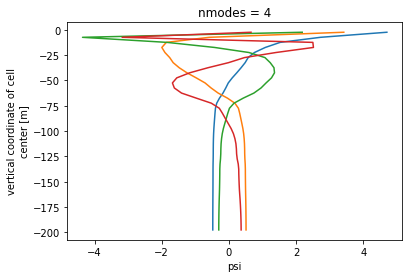

In [13]:
f,ax=plt.subplots()
df.psi[0].plot(ax=ax,y="Z")
df.psi[1].plot(ax=ax,y="Z")
df.psi[2].plot(ax=ax,y="Z")
df.psi[3].plot(ax=ax,y="Z")

In [14]:
print(df.psi[0].sum("Z").values)

0.0


In [15]:
df['ce']=xr.DataArray(ce,coords=[nmodes],dims=["nmodes"])

In [16]:
iy1=50
VW=grid.interp(ds1['VVEL'],axis=('X','Y'),boundary='extrapolate')
for iy in range(iy1,iy1+1):
    U0=(ds1['UVEL']*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    VW0=(VW*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    VS0=(ds1['VVEL'].isel(YG=iy)*ds1['drF']*ds1['hFacS']*ds1['maskS']).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).isel(YG=iy).sum('Z')
    PW=grid.interp(ds1['PHIHYD'],axis='X',boundary='extrapolate')
    PS=grid.interp(ds1['PHIHYD'],axis='Y',boundary='extrapolate')
    #print(PW[2,60:63,723:726].values)
    #print(PS[2,60:63,723:726].values)
    PW0=(PW*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy).sum('Z')/(ds1.drF*ds1.hFacW*ds1.maskW).isel(YC=iy).sum('Z')
    PS0=(PS*ds1['drF']*ds1['hFacS']*ds1['maskS']).isel(YG=iy).sum('Z')/(ds1.drF*ds1.hFacS*ds1.maskS).isel(YG=iy).sum('Z')
    #print(PW0[60:63,723:726].values)

    up=(ds1.UVEL.isel(YC=iy)-U0).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    print('processed up')
    vwp=(VW.isel(YC=iy)-VW0).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    vsp=(ds1.VVEL.isel(YG=iy)-VS0).where(ds1.maskS.isel(YG=iy)!=0,np.nan)
    print('vp')
    ppw=((PW-PW0).isel(YC=iy)).where(ds1.maskW.isel(YC=iy)!=0,np.nan)
    print('ppw')
    pps=((PS-PS0).isel(YG=iy)).where(ds1.maskS.isel(YG=iy)!=0,np.nan)
    print('pps')
    del U0,VS0,VW0,PW0,PS0

    um=(up*df.psi*ds1.drF).sum("Z")/H
    pmw=(ppw*df.psi*ds1.drF).sum("Z")/H
    vms=(vsp*df.psi*ds1.drF).sum("Z")/H
    vmw=(vwp*df.psi*ds1.drF).sum("Z")/H
    pms=(pps*df.psi*ds1.drF).sum("Z")/H
    fxm=um*pmw*H
    fym=vms*pms*H
    EKm=0.5*(um*um+vmw*vmw)*H
    EPm=0.5*(pmw*pmw/df.ce/df.ce)*H
    Em=EKm+EPm
    print(Em)
    cEm=xr.concat([-df.ce*Em[:, :720,:], df.ce*Em[:, 720:,:]], dim="XG")
    print(cEm)

BCrad=0
del vsp,pps

processed up
vp
ppw
pps
<xarray.DataArray (TidalCycles: 48, XG: 1440, nmodes: 37)>
dask.array<add, shape=(48, 1440, 37), dtype=float64, chunksize=(1, 1439, 37), chunktype=numpy.ndarray>
Coordinates:
    YC           float64 1.262e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
    dyG          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    dxC          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    rAw          (XG) float64 dask.array<chunksize=(1440,), meta=np.ndarray>
    maskInW      (XG) bool dask.array<chunksize=(1440,), meta=np.ndarray>
    iter         (TidalCycles) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    time         (TidalCycles) timedelta64[ns] 2 days 01:36:00 ... 3 days 01:...
  * TidalCycles  (TidalCycles) float64 4.0 4.042 4.083 ... 5.875 5.917 5.958
  * nmodes       (nmodes) int64 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37
<xarray.DataArray (nmodes: 37, TidalCycles: 48, XG: 1440)>
da

Text(0.5, 1.0, 'fx1 [m4/s3]')

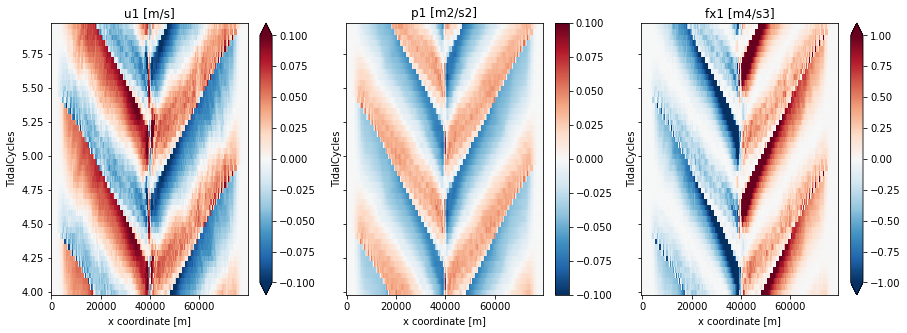

In [17]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[0].set_title("u1 [m/s]")

pmw.sel(nmodes=1).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[1].set_title("p1 [m2/s2]")

fxm.sel(nmodes=1).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-1,vmax=1,rasterized=True)
ax[2].set_title("fx1 [m4/s3]")

Text(0.5, 1.0, 'fx2 [m4/s3]')

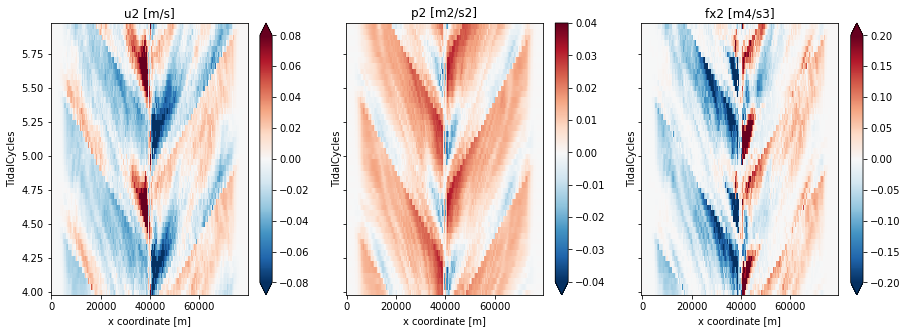

In [18]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=2).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.08,vmax=0.08,rasterized=True)
ax[0].set_title("u2 [m/s]")

pmw.sel(nmodes=2).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.04,vmax=0.04,rasterized=True)
ax[1].set_title("p2 [m2/s2]")

fxm.sel(nmodes=2).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[2].set_title("fx2 [m4/s3]")

Text(0.5, 1.0, 'fx3 [m4/s3]')

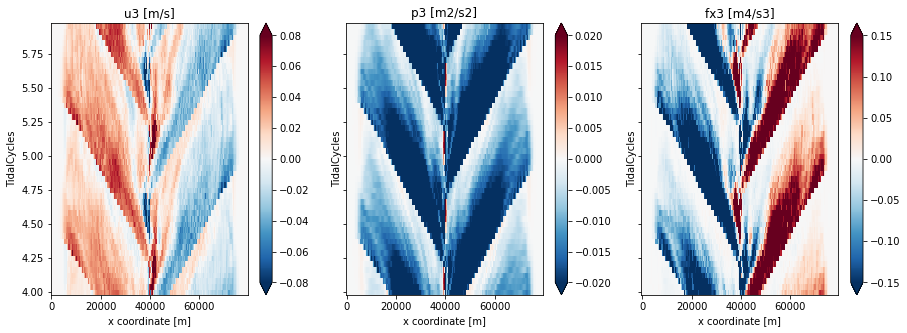

In [19]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=3).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.08,vmax=0.08,rasterized=True)
ax[0].set_title("u3 [m/s]")

pmw.sel(nmodes=3).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.02,vmax=0.02,rasterized=True)
ax[1].set_title("p3 [m2/s2]")

fxm.sel(nmodes=3).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.15,vmax=0.15,rasterized=True)
ax[2].set_title("fx3 [m4/s3]")

Text(0.5, 1.0, 'fx4 [m4/s3]')

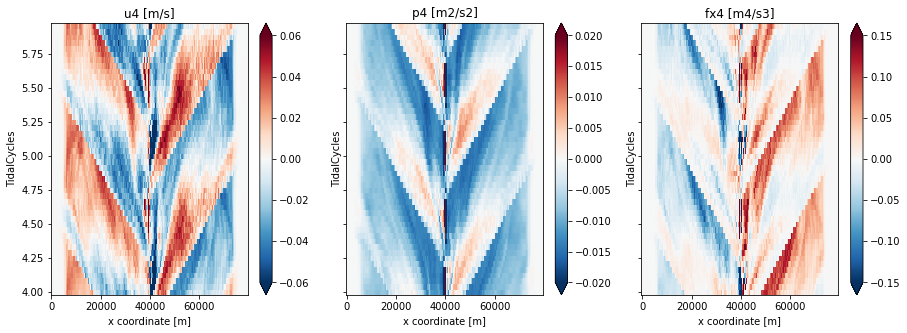

In [20]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=4).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.06,vmax=0.06,rasterized=True)
ax[0].set_title("u4 [m/s]")

pmw.sel(nmodes=4).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.02,vmax=0.02,rasterized=True)
ax[1].set_title("p4 [m2/s2]")

fxm.sel(nmodes=4).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.15,vmax=0.15,rasterized=True)
ax[2].set_title("fx4 [m4/s3]")

Text(0.5, 1.0, 'fx5 [m4/s3]')

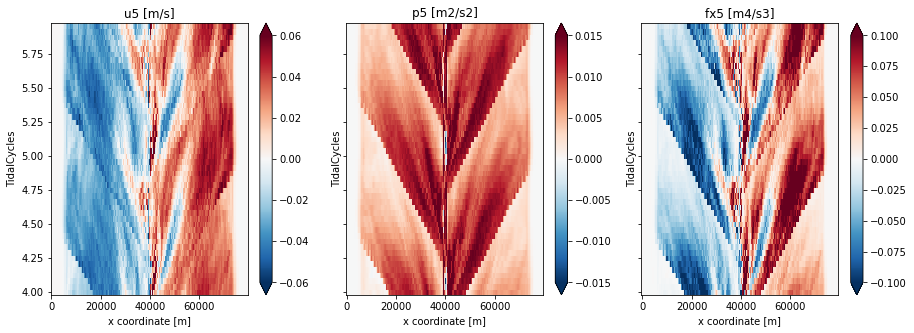

In [21]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=5).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.06,vmax=0.06,rasterized=True)
ax[0].set_title("u5 [m/s]")

pmw.sel(nmodes=5).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.015,vmax=0.015,rasterized=True)
ax[1].set_title("p5 [m2/s2]")

fxm.sel(nmodes=5).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.1,vmax=0.1,rasterized=True)
ax[2].set_title("fx5 [m4/s3]")

Text(0.5, 1.0, 'fx6 [m4/s3]')

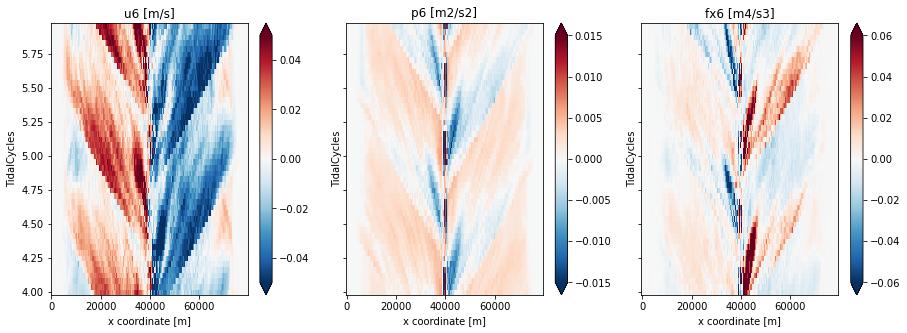

In [22]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

um.sel(nmodes=6).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.05,vmax=0.05,rasterized=True)
ax[0].set_title("u6 [m/s]")

pmw.sel(nmodes=6).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.015,vmax=0.015,rasterized=True)
ax[1].set_title("p6 [m2/s2]")

fxm.sel(nmodes=6).plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-0.06,vmax=0.06,rasterized=True)
ax[2].set_title("fx6 [m4/s3]")

Text(0.5, 1.0, 'total sum of cE')

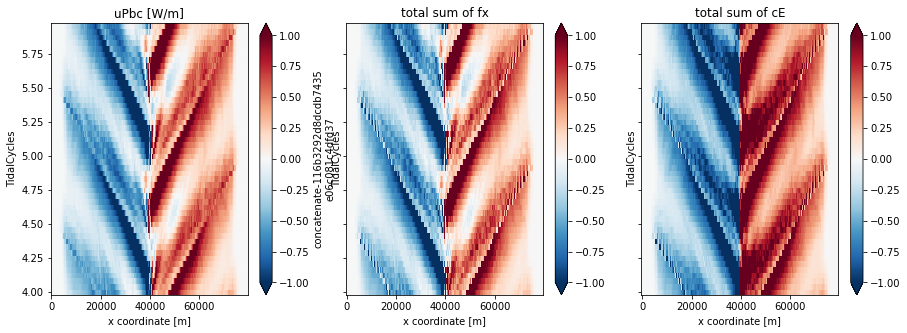

In [23]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

uPbc.isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-1,vmax=1)
ax[0].set_title("uPbc [W/m]")

fxm.sum("nmodes").plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-1,vmax=1)
ax[1].set_title("total sum of fx")

cEm.sum("nmodes").plot(ax=ax[2],y="TidalCycles",cmap="RdBu_r",vmin=-1,vmax=1)
ax[2].set_title("total sum of cE")

(-1.2, 1.2)

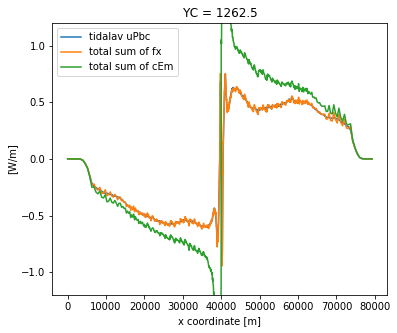

In [24]:
f, ax =plt.subplots(1,1,figsize=(6,5))

uPbc.isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav uPbc")
fxm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of fx")
cEm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of cEm")
ax.set_ylabel("[W/m]")
ax.legend()
ax.set_ylim(-1.2,1.2)

In [25]:
EK = 0.5*(ds1.UVEL*ds1.UVEL+VW*VW)
EKp = 0.5*(up*up+vwp*vwp)
print(EK)
print(EKp)

<xarray.DataArray (TidalCycles: 48, Z: 40, YC: 120, XG: 1440)>
dask.array<mul, shape=(48, 40, 120, 1440), dtype=float64, chunksize=(1, 40, 119, 1439), chunktype=numpy.ndarray>
Coordinates:
  * YC           (YC) float64 12.5 37.5 62.5 ... 2.938e+03 2.962e+03 2.988e+03
  * XG           (XG) float64 3.411e-13 713.5 1.407e+03 ... 7.859e+04 7.929e+04
  * Z            (Z) float64 -2.5 -7.5 -12.5 -17.5 ... -187.5 -192.5 -197.5
    dyG          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    dxC          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    rAw          (YC, XG) float64 dask.array<chunksize=(120, 1440), meta=np.ndarray>
    drF          (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    PHrefC       (Z) float64 dask.array<chunksize=(40,), meta=np.ndarray>
    hFacW        (Z, YC, XG) float64 dask.array<chunksize=(40, 120, 1440), meta=np.ndarray>
    maskW        (Z, YC, XG) bool dask.array<chunksize=(40, 120, 1440), meta=np.n

Text(0.5, 1.0, 'total sum of EKn')

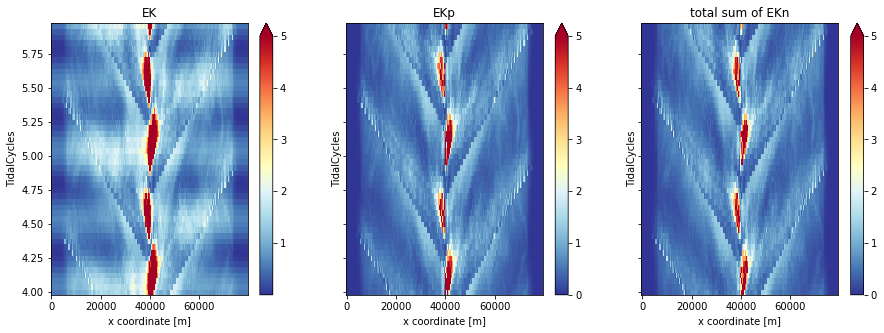

In [26]:
f, ax =plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax = ax.flatten()

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[0].set_title("EK")

(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).isel(YC=iy1).sum('Z').plot(ax=ax[1],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[1].set_title("EKp")

EKm.sum("nmodes").plot(ax=ax[2],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[2].set_title("total sum of EKn")

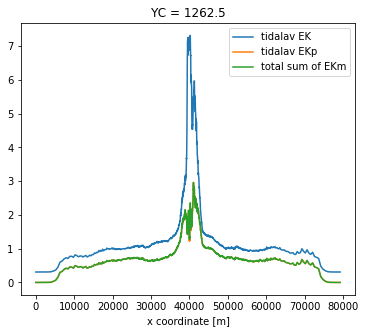

In [27]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EK*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EK")
(EKp*ds1['drF']*ds1['hFacW']*ds1['maskW']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EKp")
EKm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of EKm")
ax.legend()

In [28]:
rhow=rhoNil*(-(alpha*(ds1.THETA-ds1.tRef)))

In [29]:
print(rhow.isel(TidalCycles=0,YC=50,XC=700).values)

[ 4.06073975  0.02973198 -0.35509362  0.49387082  0.66024209  0.66734788
  0.5981472   0.50556691  0.43649599  0.37408994  0.30256829  0.29946011
  0.25544368  0.17542017  0.0997693   0.07175123  0.06365664  0.04927822
  4.81896703  4.80403047  4.79695778  4.7893723   4.78586538  4.78353814
  4.78273154  4.78116181  4.77323235  4.77202091  4.77148771  4.77062711
  4.76894027  4.76776604  4.76448568  4.76120533  4.75792497  4.75464461
  4.75136425  4.74808389  4.74480353  4.74152317]


In [30]:
EP=g*g*rhow*rhow/(2*rhoNil*rhoNil*ds1.Ns0)

Text(0.5, 1.0, 'total sum of EPn')

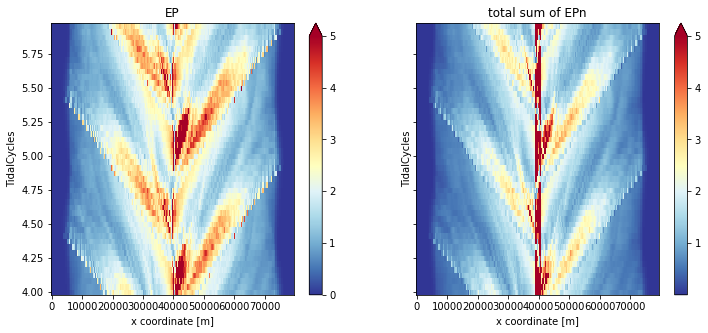

In [31]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(YC=iy1).plot(ax=ax[0],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[0].set_title("EP")

EPm.sum("nmodes").plot(ax=ax[1],y="TidalCycles",cmap="RdYlBu_r",vmax=5)
ax[1].set_title("total sum of EPn")

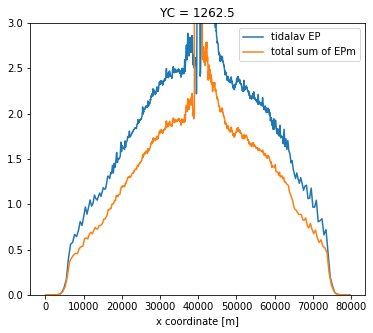

In [32]:
f, ax =plt.subplots(1,1,figsize=(6,5))

(EP*ds1['drF']*ds1['hFacC']*ds1['maskC']).sum('Z').isel(YC=iy1).mean("TidalCycles").plot(ax=ax,label="tidalav EP")
EPm.sum("nmodes").mean("TidalCycles").plot(ax=ax,label="total sum of EPm")
ax.set_ylim(0,3)
ax.legend()

Text(0.5, 1.0, 'Fx1 at Y= 1262.500000')

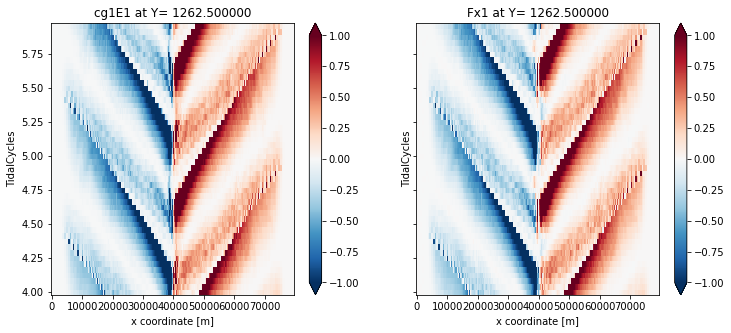

In [33]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=1).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-1,vmax=1,rasterized=True)
ax[0].set_title("cg1E1 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=1).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-1,vmax=1,rasterized=True)
ax[1].set_title("Fx1 at Y= %1f" %yc[iy1])

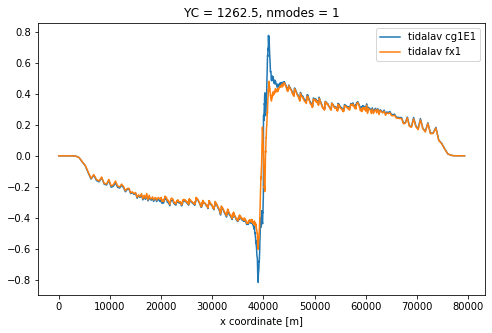

In [34]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=1).plot(ax=ax,label="tidalav cg1E1")
fxm.mean("TidalCycles").sel(nmodes=1).plot(ax=ax,label="tidalav fx1")

ax.legend()

Text(0.5, 1.0, 'Fx2 at Y= 1262.500000')

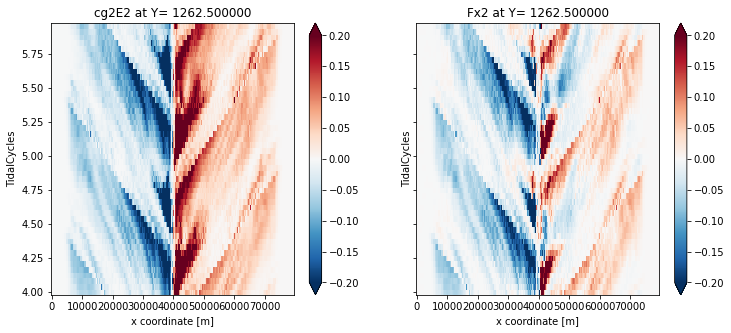

In [35]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=2).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2)
ax[0].set_title("cg2E2 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=2).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2)
ax[1].set_title("Fx2 at Y= %1f" %yc[iy1])

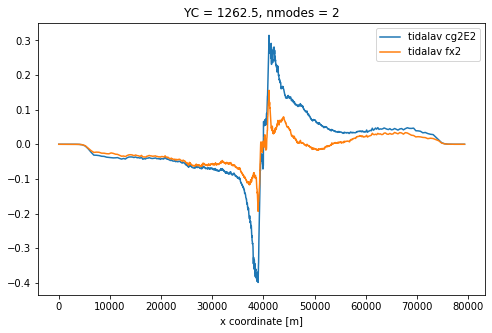

In [36]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=2).plot(ax=ax,label="tidalav cg2E2")
fxm.mean("TidalCycles").sel(nmodes=2).plot(ax=ax,label="tidalav fx2")

ax.legend()

Text(0.5, 1.0, 'Fx3 at Y= 1262.500000')

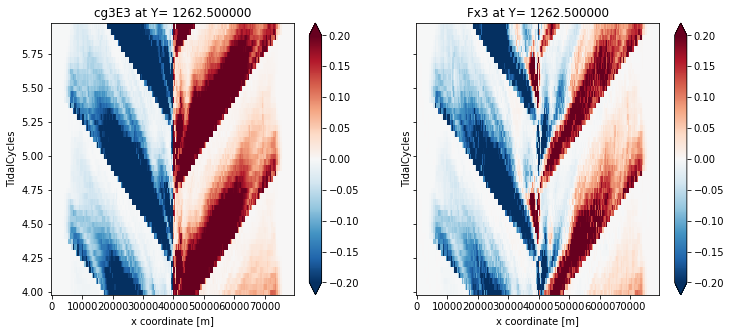

In [37]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=3).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[0].set_title("cg3E3 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=3).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.2,vmax=0.2,rasterized=True)
ax[1].set_title("Fx3 at Y= %1f" %yc[iy1])

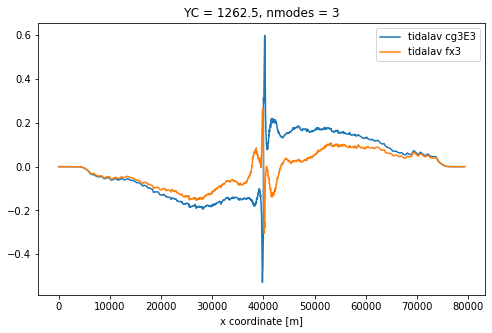

In [38]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=3).plot(ax=ax,label="tidalav cg3E3")
fxm.mean("TidalCycles").sel(nmodes=3).plot(ax=ax,label="tidalav fx3")

ax.legend()

Text(0.5, 1.0, 'Fx4 at Y= 1262.500000')

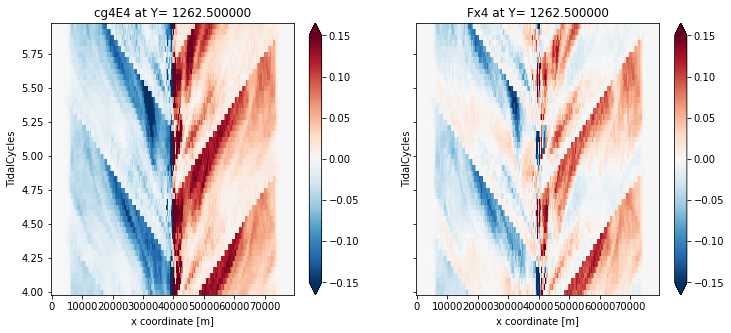

In [39]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=4).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.15,vmax=0.15)
ax[0].set_title("cg4E4 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=4).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.15,vmax=0.15)
ax[1].set_title("Fx4 at Y= %1f" %yc[iy1])

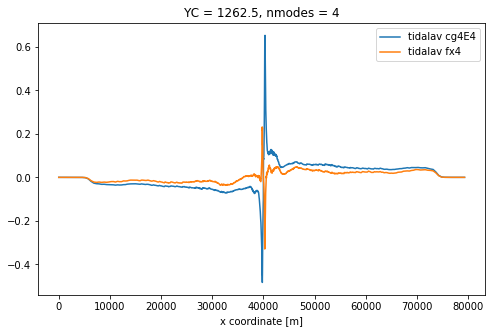

In [40]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=4).plot(ax=ax,label="tidalav cg4E4")
fxm.mean("TidalCycles").sel(nmodes=4).plot(ax=ax,label="tidalav fx4")

ax.legend()

Text(0.5, 1.0, 'Fx5 at Y= 1262.500000')

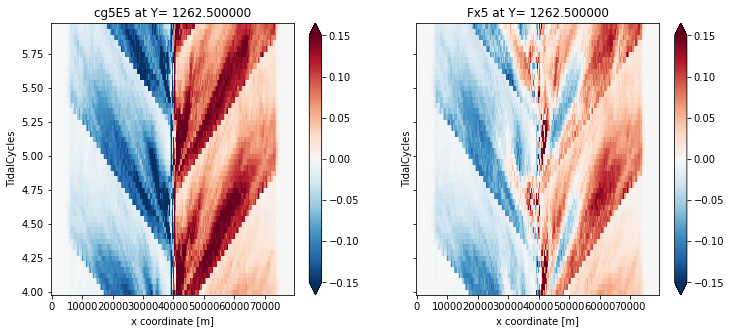

In [41]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=5).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.15,vmax=0.15,rasterized=True)
ax[0].set_title("cg5E5 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=5).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.15,vmax=0.15,rasterized=True)
ax[1].set_title("Fx5 at Y= %1f" %yc[iy1])

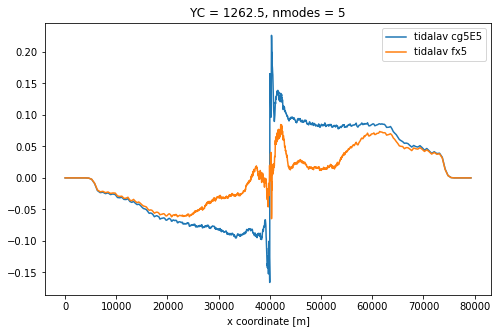

In [42]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=5).plot(ax=ax,label="tidalav cg5E5")
fxm.mean("TidalCycles").sel(nmodes=5).plot(ax=ax,label="tidalav fx5")

ax.legend()

Text(0.5, 1.0, 'Fx6 at Y= 1262.500000')

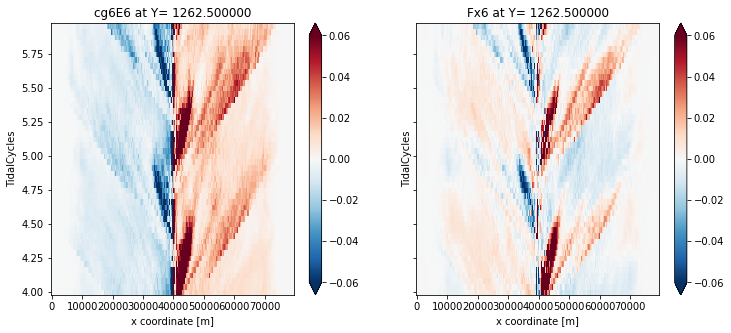

In [43]:
f, ax =plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
ax = ax.flatten()

cEm.sel(nmodes=6).plot(ax=ax[0],y="TidalCycles",cmap="RdBu_r",vmin=-0.06,vmax=0.06,rasterized=True)
ax[0].set_title("cg6E6 at Y= %1f" %yc[iy1])

fxm.sel(nmodes=6).plot(ax=ax[1],y="TidalCycles",cmap="RdBu_r",vmin=-0.06,vmax=0.06,rasterized=True)
ax[1].set_title("Fx6 at Y= %1f" %yc[iy1])

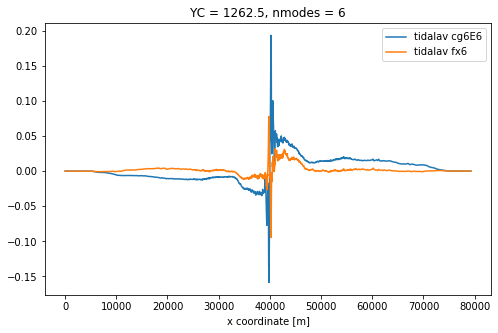

In [44]:
f, ax =plt.subplots(1,1,figsize=(8,5))

cEm.mean("TidalCycles").sel(nmodes=6).plot(ax=ax,label="tidalav cg6E6")
fxm.mean("TidalCycles").sel(nmodes=6).plot(ax=ax,label="tidalav fx6")

ax.legend()